# 랜덤포레스트(RF) & 배깅 (Bagging) & 보팅(Voting)

In [102]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_iris,load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

In [5]:
# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#   return [acc, pre, rec, f1]

# 다중 분류 지표 출력
def get_multiclf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred, average='micro')
    rec = recall_score(y_test,pred, average='macro')
    f1 = f1_score(y_test,pred, average='weighted')
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#   return [acc, pre, rec, f1]

# roc curve
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', color='k', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

## 보팅(Voting Classifier)

In [7]:
# 데이터 불러오기
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
print('cancer_df.shape :',cancer_df.shape)
cancer_df.head()

cancer_df.shape : (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, shuffle=True,
                                                   random_state=42, stratify=cancer.target)

In [30]:
# 보팅 학습기 생성
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

voting_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

In [32]:
# 교차 검정 수행
lr_score = cross_val_score(lr_clf, X_train, y_train, cv=5, scoring='accuracy')
knn_score = cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='accuracy')
voting_score = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')

print('lr_score :',np.round(lr_score.mean(),2))
print('knn_score :',np.round(knn_score.mean(),2))
print('voting_score :',np.round(voting_score.mean(),2))

lr_score : 0.94
knn_score : 0.94
voting_score : 0.95


In [33]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(n_neighbors=8))],
                 voting='soft')

In [37]:
voting_clf.estimators_

[LogisticRegression(), KNeighborsClassifier(n_neighbors=8)]

In [38]:
pred=voting_clf.predict(X_test)
get_clf_eval(y_test,pred)

[[37  5]
 [ 1 71]]
정확도 :0.9474, 정밀도 :0.9342, 재현율 :0.9861, F1 :0.9595


ROC AUC Score : 0.9335


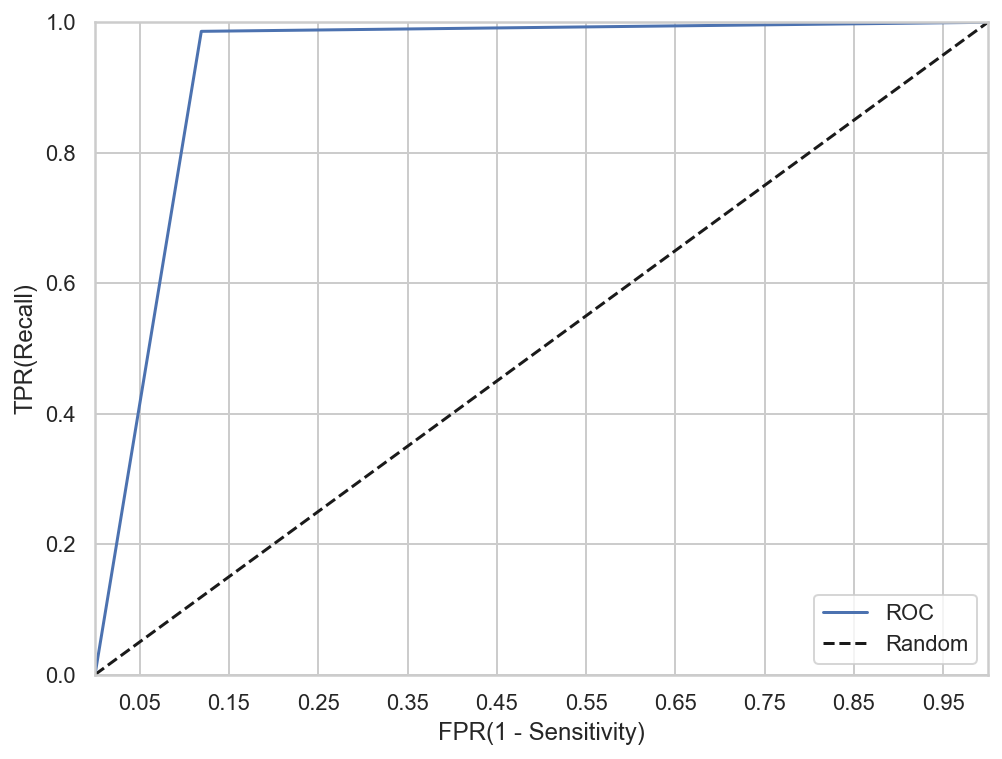

In [40]:
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC Score : {0:.4f}'.format(roc_score))
roc_curve_plot(y_test,pred)

## 배깅(Bagging Classifier)

In [43]:
# 배깅 학습기 생성
knn_clf = KNeighborsClassifier(n_neighbors=8)

bagging_clf = BaggingClassifier(base_estimator = knn_clf, n_estimators=10, random_state=42, oob_score=True)

In [45]:
# 교차 검증
knn_score = cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='accuracy')
bagging_score = cross_val_score(bagging_clf, X_train, y_train, cv=5, scoring='accuracy')

print('knn_score :',np.round(knn_score.mean(),2))
print('bagging_score :',np.round(bagging_score.mean(),2))

knn_score : 0.94
bagging_score : 0.94


In [46]:
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=8),
                  oob_score=True, random_state=42)

In [49]:
bagging_clf.oob_score_

0.9340659340659341

In [50]:
pred=bagging_clf.predict(X_test)
get_clf_eval(y_test,pred)

[[38  4]
 [ 4 68]]
정확도 :0.9298, 정밀도 :0.9444, 재현율 :0.9444, F1 :0.9444


ROC AUC Score : 0.9246


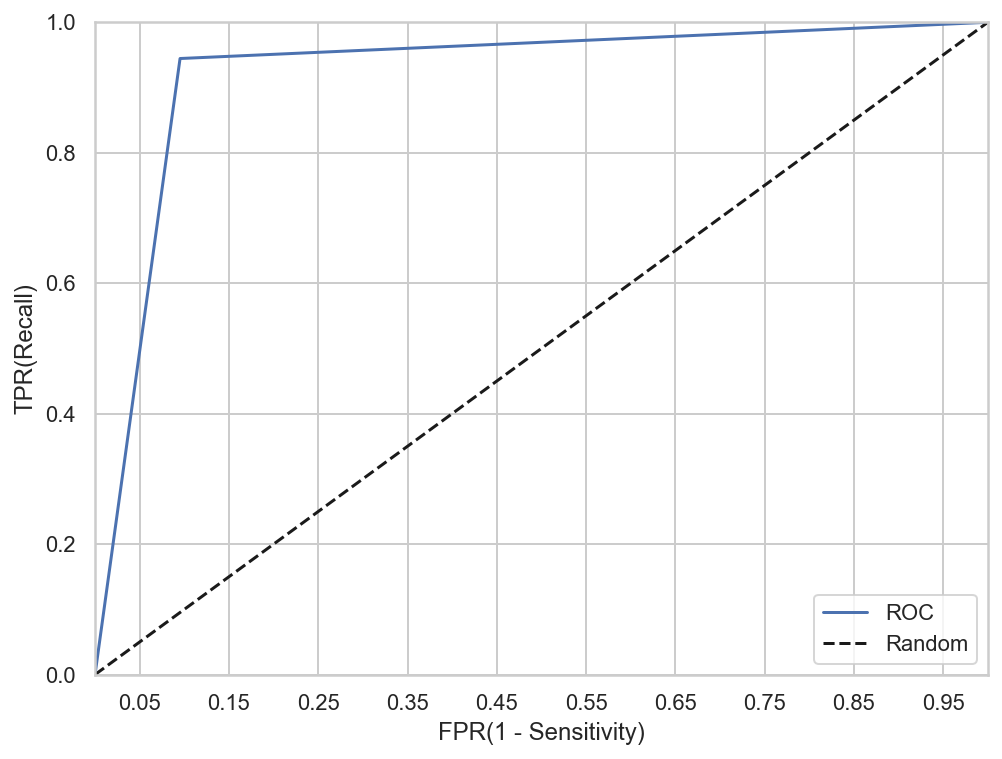

In [51]:
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC Score : {0:.4f}'.format(roc_score))
roc_curve_plot(y_test,pred)

## 랜덤포레스트(RandomForest)

### 랜덤포레스트 분류기

In [60]:
# 데이터 불러오기
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
print('cancer_df.shape :',cancer_df.shape)
cancer_df.head()

cancer_df.shape : (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [61]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, shuffle=True,
                                                   random_state=42, stratify=cancer.target)

In [72]:
# 하이퍼파라미터 튜닝
rf_clf = RandomForestClassifier(random_state=42, oob_score=True)

param_grid = {
    'n_estimators':[50],
    'max_depth':[4,6,8,10],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

grid_cv = GridSearchCV(rf_clf, cv=3, refit=True, param_grid=param_grid)
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [50]})

In [77]:
print("grid_cv.best_params_ :",grid_cv.best_params_)
print('grid_cv.best_score_ :',grid_cv.best_score_)

grid_cv.best_params_ : {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 50}
grid_cv.best_score_ : 0.9538457069826886


In [69]:
best = grid_cv.best_estimator_
pred = best.predict(X_test)
get_clf_eval(y_test,pred)

[[39  3]
 [ 3 69]]
정확도 :0.9474, 정밀도 :0.9583, 재현율 :0.9583, F1 :0.9583


roc_auc_score : 0.943452380952381


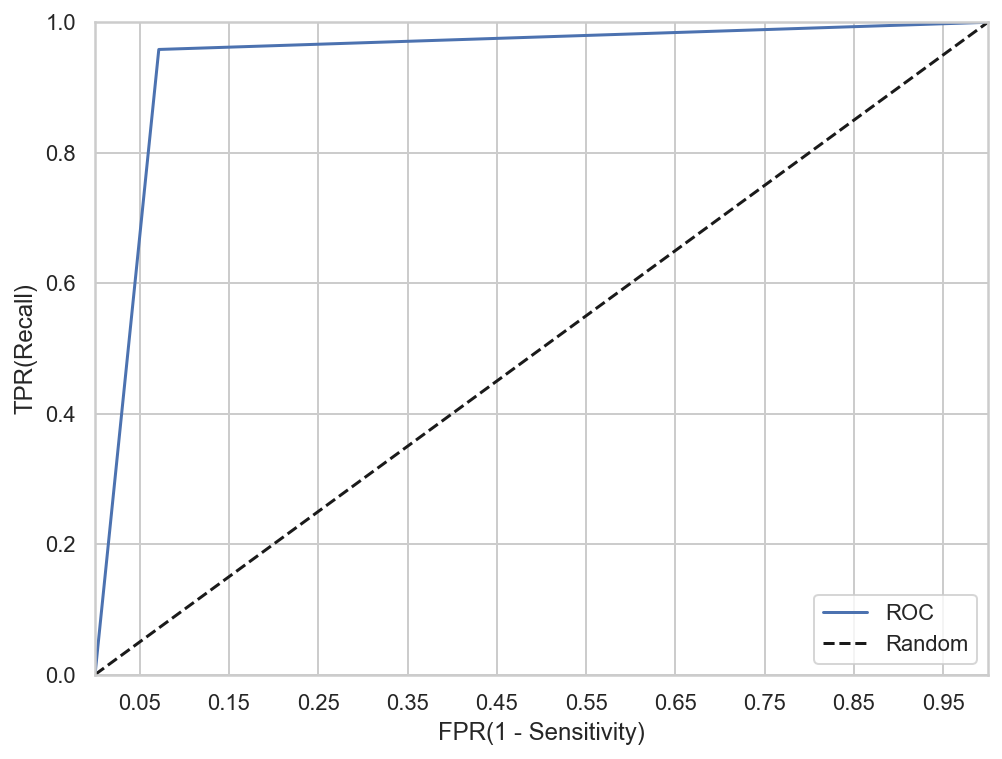

In [71]:
print('roc_auc_score :',roc_auc_score(y_test,pred))
roc_curve_plot(y_test, pred)

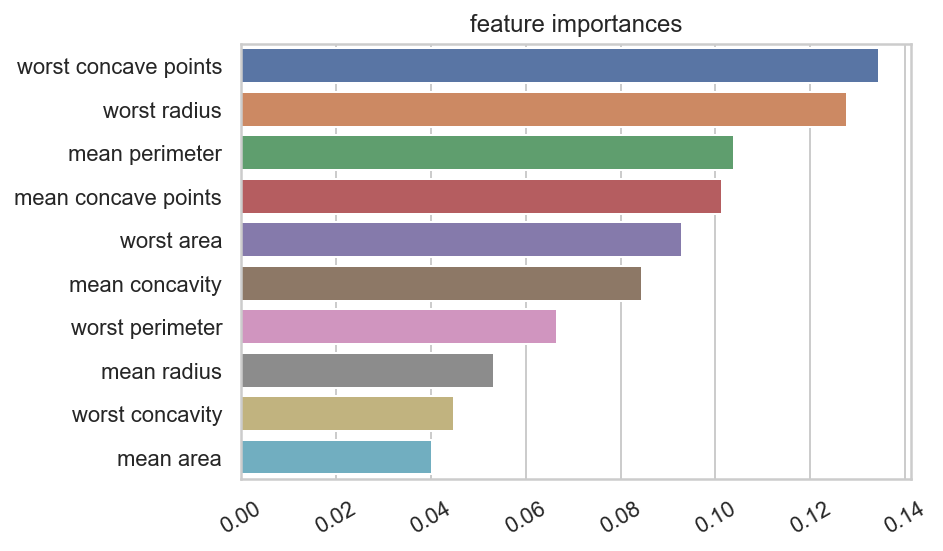

In [100]:
feature_imp = best.feature_importances_
imp_series = pd.Series(feature_imp, cancer_df.columns).sort_values(ascending=False)[:10]
plt.title('feature importances')
sns.barplot(np.round(imp_series.values,6), imp_series.index)
plt.xticks(rotation=30)
plt.show()

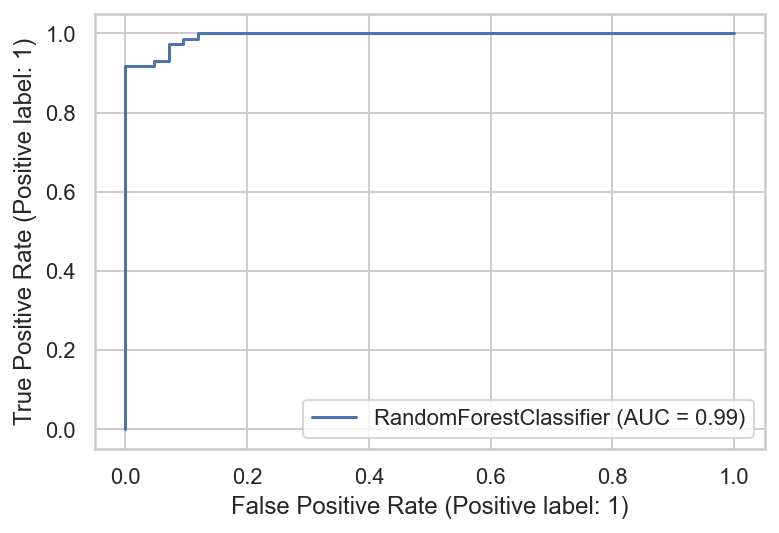

In [104]:
plot_roc_curve(best, X_test, y_test)
plt.show()